In [70]:
# Import all dependencies

import numpy as np
import pandas as pd 
import matplotlib.pylab as plt
from matplotlib import dates

from sklearn.linear_model import LinearRegression

%matplotlib inline 

import warnings
warnings.filterwarnings('ignore')

In [71]:
# read csv in the dataframe

df= pd.read_csv("ane_energy/df_merged.csv", parse_dates=['dt_start_utc'], index_col='dt_start_utc')

<AxesSubplot:xlabel='dt_start_utc'>

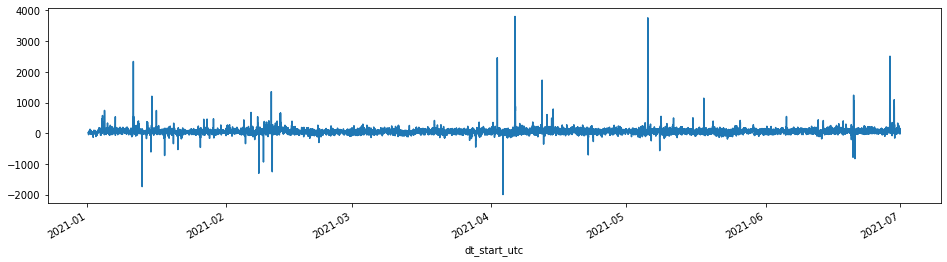

In [72]:
# Let's illustrate the data

df["rebap_eur_mwh"].plot(figsize=(16,4))

<AxesSubplot:xlabel='dt_start_utc'>

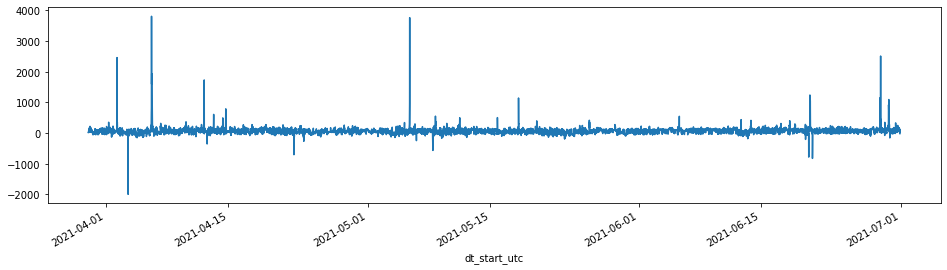

In [73]:
# The way we access our timestamp values now changes

df["rebap_eur_mwh"]['2021-03-30':'2021-06-30'].plot(figsize=(16,4))

In [74]:
df["rz_saldo_mwh"]

dt_start_utc
2021-01-01 06:15:00   -24.0
2021-01-01 06:30:00   -80.0
2021-01-01 06:45:00    26.0
2021-01-01 07:00:00    53.0
2021-01-01 07:15:00    73.0
                       ... 
2021-06-30 20:45:00   -79.0
2021-06-30 21:00:00   -91.0
2021-06-30 21:15:00   -57.0
2021-06-30 21:30:00     4.0
2021-06-30 21:45:00   -62.0
Name: rz_saldo_mwh, Length: 17292, dtype: float64

In [75]:
rebap = df[["rebap_eur_mwh" ]]

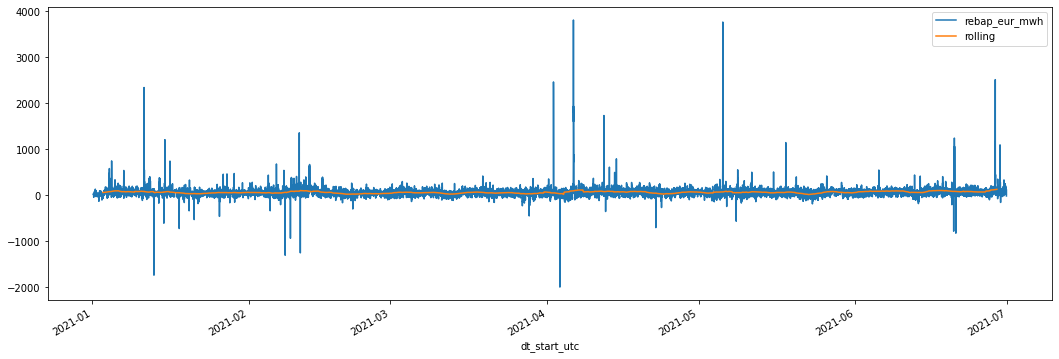

In [76]:
# to identify signal is to substantially smooth our time series

(
    rebap
    .assign(rolling = lambda df: rebap["rebap_eur_mwh"].rolling(365, center=True).mean(),
            #exponential=lambda df: df['aqi'].ewm(alpha=0.001).mean()
           )
    .plot(figsize=(18,6))

);

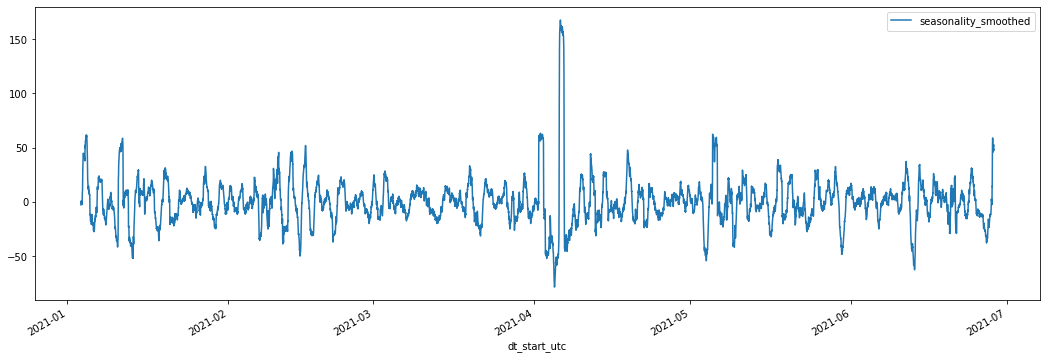

In [77]:
# seasonality with a lot of noise, which can´t turn smoothed out as well

(
    rebap
    .assign(rolling = lambda df: rebap["rebap_eur_mwh"].rolling(365, center=True).mean(),
            seasonality = lambda df: rebap["rebap_eur_mwh"] - df['rolling'],
            seasonality_smoothed = lambda df: df['seasonality'].rolling(90, center=True).mean()
           )
    .loc['2021':'2021']
    #[['seasonality','seasonality_smoothed']]
    [['seasonality_smoothed']]
    .plot(figsize=(18,6))

);

In [78]:
# single time component can inform us about the general trend

rebap['time'] = np.arange(len(rebap.index))

X = rebap[['time']]
y = rebap["rebap_eur_mwh"].values

In [79]:
#fitting a linear model

lm = LinearRegression()
lm.fit(X, y)

rebap['linear_trend'] = lm.predict(X)

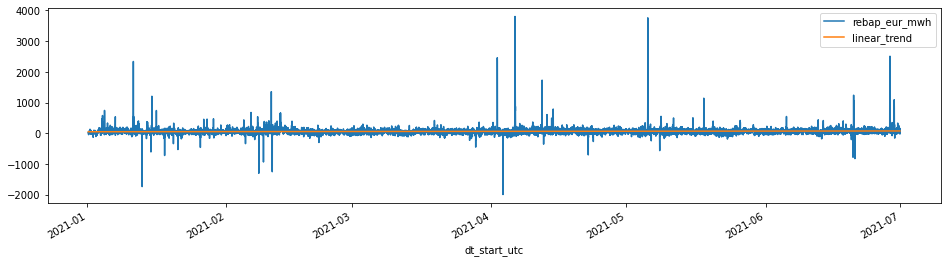

In [80]:
# plot the linear trend

rebap[["rebap_eur_mwh",'linear_trend']].plot(figsize=(16,4));

In [81]:
rebap.index

DatetimeIndex(['2021-01-01 06:15:00', '2021-01-01 06:30:00',
               '2021-01-01 06:45:00', '2021-01-01 07:00:00',
               '2021-01-01 07:15:00', '2021-01-01 07:30:00',
               '2021-01-01 07:45:00', '2021-01-01 08:00:00',
               '2021-01-01 08:15:00', '2021-01-01 08:30:00',
               ...
               '2021-06-30 19:30:00', '2021-06-30 19:45:00',
               '2021-06-30 20:00:00', '2021-06-30 20:15:00',
               '2021-06-30 20:30:00', '2021-06-30 20:45:00',
               '2021-06-30 21:00:00', '2021-06-30 21:15:00',
               '2021-06-30 21:30:00', '2021-06-30 21:45:00'],
              dtype='datetime64[ns]', name='dt_start_utc', length=17292, freq=None)

In [82]:
rebap

,rebap_eur_mwh,time,linear_trend
dt_start_utc,,,
2021-01-01 06:15:00,17.78,0,47.364073
2021-01-01 06:30:00,24.77,1,47.365539
2021-01-01 06:45:00,32.96,2,47.367005
2021-01-01 07:00:00,13.25,3,47.368472
2021-01-01 07:15:00,2.36,4,47.369938
...,...,...,...
2021-06-30 20:45:00,119.06,17287,72.712045
2021-06-30 21:00:00,3.10,17288,72.713511
2021-06-30 21:15:00,125.68,17289,72.714977


In [83]:
# adding break indicators & interaction terms

X_break = (
    rebap
    .assign(after2021 = [1 if el>pd.Timestamp('2021-3') else 0 for el in rebap.index],
            interaction = lambda df: df['time']*df['after2021'])
    [['time', 'after2021','interaction']]
)

lm_break = LinearRegression().fit(X_break, y)

rebap['linear_trend_break'] = lm_break.predict(X_break)

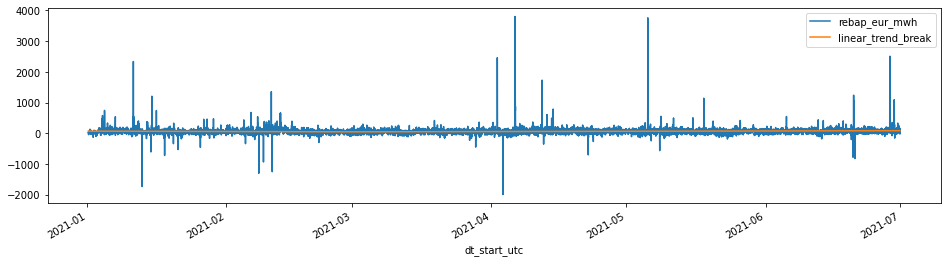

In [84]:
# plot the linear trend

rebap[['rebap_eur_mwh','linear_trend_break']].plot(figsize=(16,4));

In [85]:
# Import all dependencies

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [98]:
#identifying months and preprocessing them

rebap['month']=rebap.index.month

#train-test split
rebap_train = rebap.loc[:'2021-3'].copy()
rebap_test = rebap.loc['2021-4':].copy()

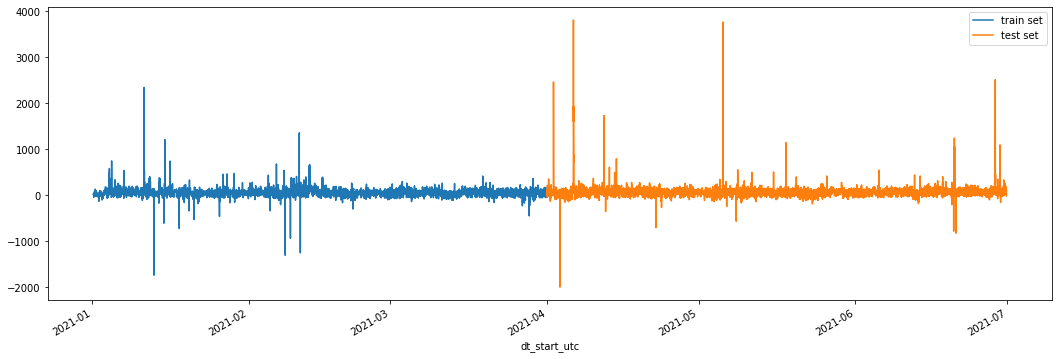

In [99]:
#train-test split illustrated

fig, ax = plt.subplots(figsize=(18,6))
rebap_train[['rebap_eur_mwh']].plot(ax=ax)
rebap_test[['rebap_eur_mwh']].plot(ax=ax)
plt.legend(["train set","test set"]);

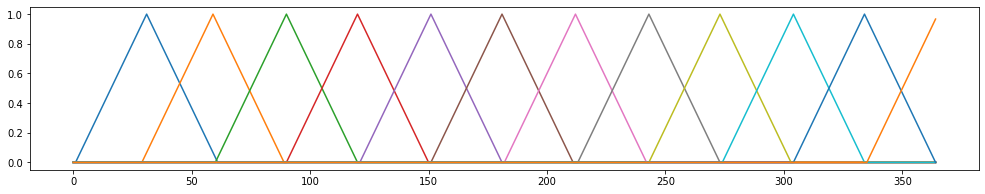

In [103]:
# Gradual Seasonal Filtering
# a filter like this translates into a variable with values the closer to 1 (or to 0), the closer (or the further) a particular date is from the given peak.

months = pd.date_range('2021-01-01', periods = 12, freq = 'M')

fig, ax = plt.subplots(figsize=(17,3))
for month in months:
    ax.plot([gsf_feature_maker(el, month.dayofyear) for el in np.arange(365)])

In [105]:
#determining month starting days as day of the year numbers

rebap_gsf=rebap[['rebap_eur_mwh','time']].copy()
rebap_gsf['month']=rebap_gsf.index.month
rebap_gsf['dayofyear']=rebap_gsf.index.dayofyear


month_start_days=[]
for i in range(1,7):
    month_start_days.append(rebap_gsf.loc[lambda df: df.month==i].iloc[0]['dayofyear'])
    
month_start_days

[1.0, 32.0, 60.0, 91.0, 121.0, 152.0]

In [108]:
#Adding 6 GSF features to the dataset

for i in range(6):
    feature_name="f"+str(i)
    peak = month_start_days[i]
    rebap_gsf[feature_name] = [gsf_feature_maker(date.dayofyear, peak) for date in rebap_gsf.index]

In [109]:
rebap_gsf.head()

,rebap_eur_mwh,time,month,dayofyear,f0,f1,f2,f3,f4,f5
dt_start_utc,,,,,,,,,,
2021-01-01 06:15:00,17.78,0,1,1,1.0,0.0,0.0,0.0,0.0,0.0
2021-01-01 06:30:00,24.77,1,1,1,1.0,0.0,0.0,0.0,0.0,0.0
2021-01-01 06:45:00,32.96,2,1,1,1.0,0.0,0.0,0.0,0.0,0.0
2021-01-01 07:00:00,13.25,3,1,1,1.0,0.0,0.0,0.0,0.0,0.0
2021-01-01 07:15:00,2.36,4,1,1,1.0,0.0,0.0,0.0,0.0,0.0


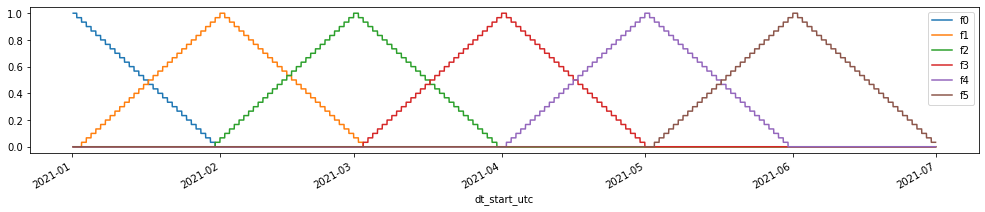

In [111]:
#inspecting the new features visually

fig, ax = plt.subplots(figsize=(17,3))
for i in range(6):
    feature_name="f"+str(i)
    rebap_gsf[[feature_name]].loc[:'2021'].plot(ax=ax)

In [113]:
# Linear Regression

X_gsf = np.c_[rebap_gsf[['time']], rebap_gsf.iloc[:,4:]]
X_gsf_train = np.c_[rebap_gsf[['time']].loc[:'2021-4'], rebap_gsf.iloc[:,4:].loc[:'2021-4']]
y_train = rebap_gsf['rebap_eur_mwh'].loc[:'2021-4']

lm_gsf = LinearRegression().fit(X_gsf_train, y_train)
print(f"R^2 is {round(lm_gsf.score(X_gsf_train, y_train),3)}")

rebap_gsf['gsf_pred'] = lm_gsf.predict(X_gsf)

R^2 is 0.004


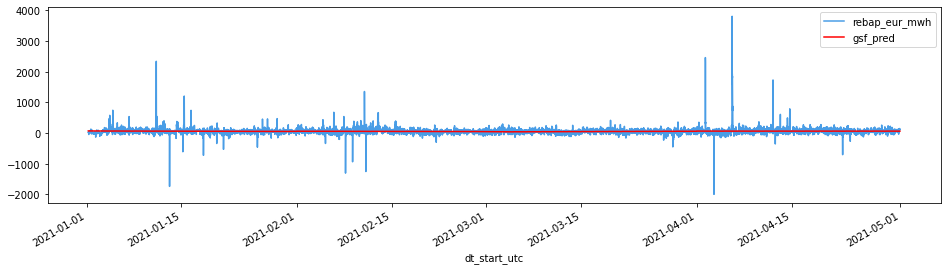

In [115]:
# plot the Gradual Seasonal Filtering Prediction

rebap_gsf[['rebap_eur_mwh','gsf_pred']].loc[:'2021-4'].plot(figsize=(16,4), color=['#499DE6','red']);

In [121]:
# Outlier detection

rebap_gsf['rebap_eur_mwh'].iloc[0]

17.78

In [122]:
# detecting datapoints deviating more than 20% from the model
outliers=[]

for i in range(len(rebap_gsf)):
    
    if np.abs(rebap_gsf['rebap_eur_mwh'].iloc[i]-rebap_gsf['gsf_pred'].iloc[i])/rebap_gsf['gsf_pred'].iloc[i]>0.15:
        outliers.append(rebap_gsf['rebap_eur_mwh'].iloc[i])
    else:
        outliers.append(np.nan)

rebap_gsf['outliers']=outliers

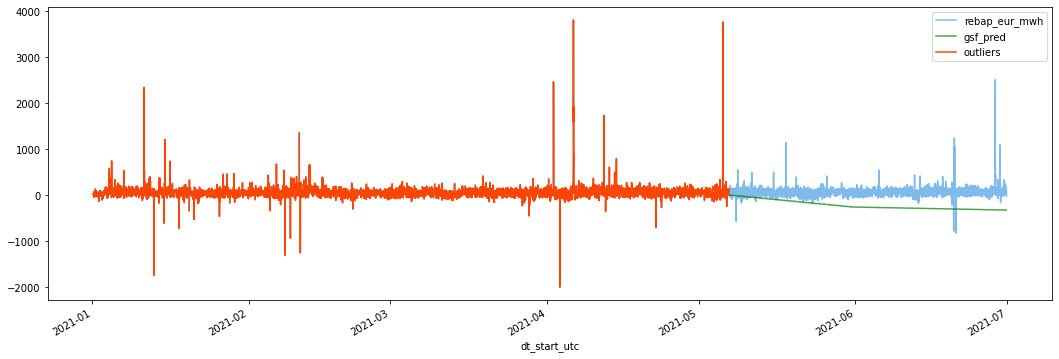

In [123]:
# illustrating outliers

fig, ax = plt.subplots(figsize=(18,6))
rebap_gsf[['rebap_eur_mwh','gsf_pred']].loc[:'2021'].plot(color=['#499DE6','green'], ax=ax, alpha=0.7)
rebap_gsf[['outliers']].loc[:'2021'].plot(color='orangered', ax=ax);

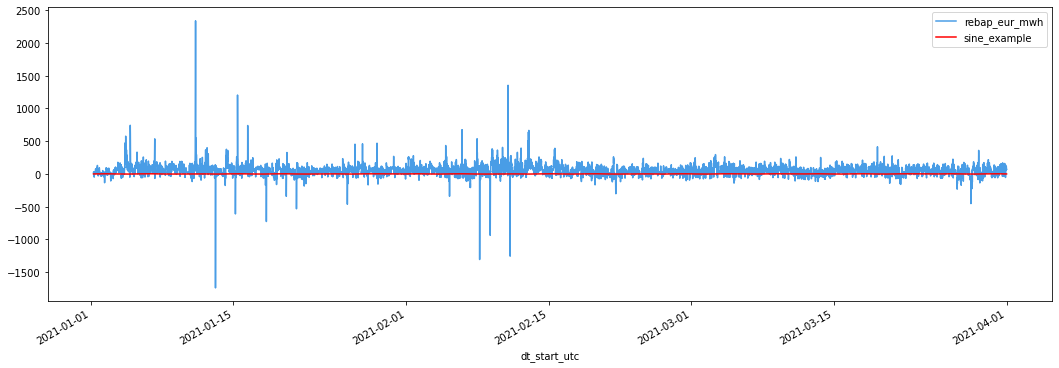

In [125]:
# Fitting a Sine Curve

rebap_train['sine_example']=2*np.sin(0.015*rebap_train['time'])

rebap_train[['rebap_eur_mwh', 'sine_example']].plot(figsize=(18,6), color=['#499DE6','red']);

In [126]:
# calculate the sin and cos components as new variables

sin_df = (
    rebap[['rebap_eur_mwh','time']]
    .assign(sin = lambda df: np.sin(2*np.pi*df.time/365),
            cos = lambda df: np.cos(2*np.pi*df.time/365),
            #sin_time = lambda df: df.sin*df.time,
            #cos_time = lambda df: df.cos*df.time
        
    )

)

In [127]:
sin_df.head()

,rebap_eur_mwh,time,sin,cos
dt_start_utc,,,,
2021-01-01 06:15:00,17.78,0,0.000000,1.000000
2021-01-01 06:30:00,24.77,1,0.017213,0.999852
2021-01-01 06:45:00,32.96,2,0.034422,0.999407
2021-01-01 07:00:00,13.25,3,0.051620,0.998667
2021-01-01 07:15:00,2.36,4,0.068802,0.997630


In [128]:
# train-test split

X_sin = sin_df.iloc[:,1:]
X_sin_train = X_sin.loc[:'2021-4']

In [129]:
# Linear Regression

lm_sin = LinearRegression().fit(X_sin_train, y_train)
print(f"R^2 is {round(lm_sin.score(X_sin_train, y_train),3)}")

sin_df['rebap_eur_mwh_pred'] = lm_sin.predict(X_sin)

R^2 is 0.003


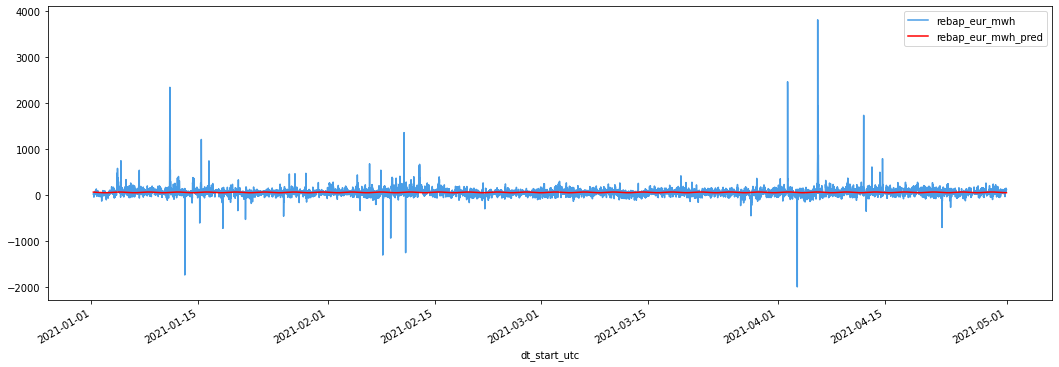

In [130]:
# plot Prediction‚

sin_df[['rebap_eur_mwh','rebap_eur_mwh_pred']].loc[:'2021-4'].plot(figsize=(18,6), color=['#499DE6','red']);

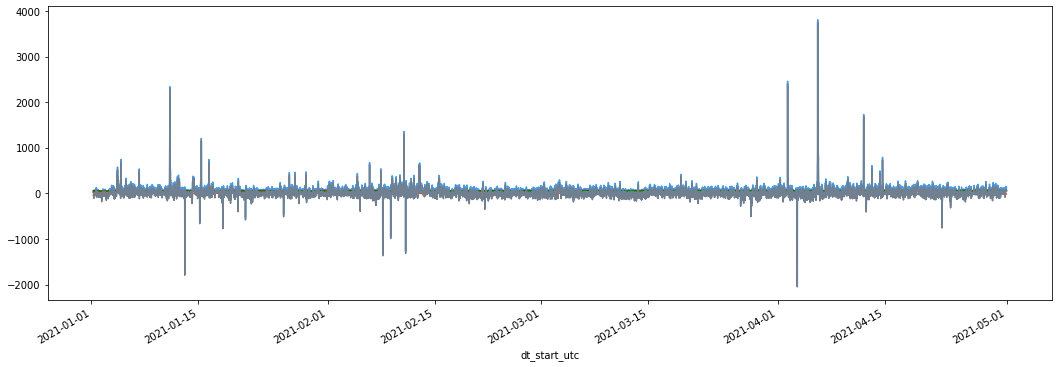

In [131]:
# perform the error-trend-seasonality decomposition

sin_df['trend'] = lm.intercept_+lm.coef_[0]*np.arange(len(rebap.index))
sin_df['seasonal'] = sin_df['rebap_eur_mwh_pred'] - sin_df['trend']
sin_df['resid'] = sin_df['rebap_eur_mwh'] - sin_df['rebap_eur_mwh_pred']

(
    sin_df[['rebap_eur_mwh','rebap_eur_mwh_pred','trend', 'seasonal', 'resid']]
    .loc[:'2021-4']
    .plot(figsize=(18,6), legend=False, color=['#499DE6','red', 'green', 'orangered', 'slategrey'])
);